### Part-A: 
• DOMAIN: Botanical Research

• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo.

• DATA DESCRIPTION: The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data.

• PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo


#### Import Libraries


In [5]:
import tensorflow as tf
tf.__version__

import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
     

Found GPU at: /device:GPU:0


**1. Import the data. Analyse the dimensions of the data. Visualise the data** 

a) Import the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Extract ‘plant-seedlings-classification.zip’ into new folder

In [4]:
project_path = '/content/gdrive/MyDrive/computervision/CV_PROJECT1/plant-seedlings-classification.zip'  


b) Analyse the dimensions of the data

In [5]:
# Extracting the dataset.zip to the present working directory
from zipfile import ZipFile
with ZipFile(project_path,'r') as zip:
  zip.extractall()

In [7]:
#Check the list of files in the pwd(present working directory)
!ls

gdrive	__MACOSX  plant-seedlings-classification  sample_data


In [13]:
paths = glob.glob("/content/plant-seedlings-classification/train/*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format(label_names))

Total labels: 12
Labels: ['Fat Hen', 'Common wheat', 'Loose Silky-bent', 'Maize', 'Shepherds Purse', 'Cleavers', 'Small-flowered Cranesbill', 'Charlock', 'Black-grass', 'Common Chickweed', 'Sugar beet', 'Scentless Mayweed']


**b) Analyse the dimensions of the data**


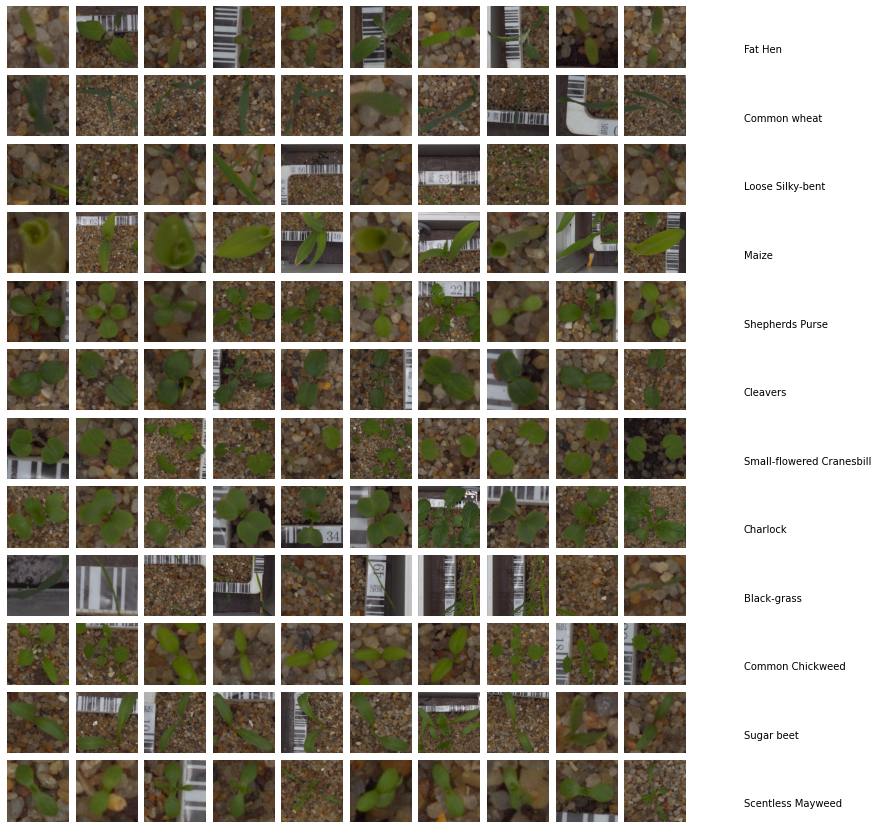

In [14]:
#Exploring Data
fig = plt.figure(1, (20, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("plant-seedlings-classification/train", label, "*.png"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

In [15]:
img.shape

(150, 150, 3)

**Reading Images**

In this step, we simply store the path to our image dataset into a variable and then we create a function to load folders containing images into arrays so that computers can deal with it

In [16]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "plant-seedlings-classification/train"

In [17]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [18]:
len(images)

4750

**Image Data Augmentation for Deep Learning and CNN**

In [26]:
# Image augmentation
TRAIN_FOLDER= "plant-seedlings-classification/train"
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, vertical_flip=True,
        validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
        TRAIN_FOLDER,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode='categorical', subset='training' )
validation_generator = validation_datagen.flow_from_directory(
        TRAIN_FOLDER,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode='categorical', subset='validation', shuffle=False)
     

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [27]:
train_count = train_generator.samples
print('Number of training Batches: ',int(train_count/32))

Number of training Batches:  118


In [28]:
val_count = validation_generator.samples
print('Number of validation Batches: ',int(val_count/32))

Number of validation Batches:  29


In [29]:
# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(train_count/32)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 117/117 [01:18<00:00,  1.50it/s]

(3776, 128, 128, 3) (3776, 12)


In [30]:
# Store the data in X_val, y_val variables by iterating over the batches
validation_generator.reset()
X_val, y_val = next(validation_generator)
for i in tqdm(range(int(val_count/32)-1)):
  img, label = next(validation_generator)
  X_val = np.append(X_val, img, axis=0 )
  y_val = np.append(y_val, label, axis=0)
print(X_val.shape, y_val.shape)
     

100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

(928, 128, 128, 3) (928, 12)


In [31]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3776, 128, 128, 3) (3776, 12) (928, 128, 128, 3) (928, 12)


In [32]:
seedlings_dict = train_generator.class_indices
print('Available classes: ', seedlings_dict)
seedlings_dict.values
a = list(seedlings_dict.items())
seedlings_np = np.array(a)
seedlings = seedlings_np[:,0]
print('\n After converting the dictionary into simple array: \n', seedlings)
print('\n Referencing a class with index: ', seedlings[10])

Available classes:  {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}

 After converting the dictionary into simple array: 
 ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']

 Referencing a class with index:  Small-flowered Cranesbill


**c) Visualize the data**

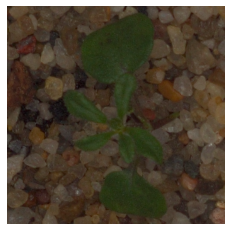

Cleavers


In [35]:
#Visualize one image
plt.subplots(1)
img = Image.open(project_path + '/Cleavers/0a1e622bc.png')
plt.imshow(img)
plt.axis('off')
plt.show()
print(seedlings[2])

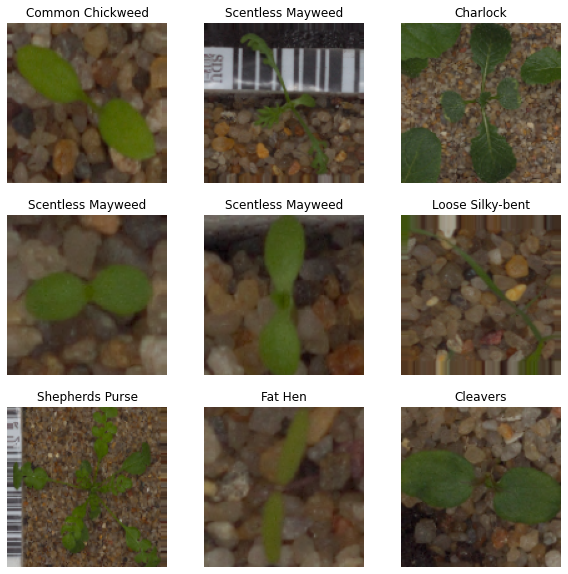

In [36]:
# Visualize some random 9 images from the train_data batch dataset
train_generator.reset()
image_batch, label_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image_batch[i])
  label = label_batch[i].astype('uint8')
  #print(label.argmax())
  plt.title(seedlings[label.argmax()])
  #print(label)
  plt.axis('off')

**Resizing images**: Some images captured by a camera and fed to our AI algorithm vary in size, therefore, we should establish a base size for all images fed into our AI algorithms by resizing them.

In [40]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [41]:
images[0].shape

(256, 256, 3)

In [42]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4750, 256, 256, 3)
classes shape:  (4750,)


**Image Classification**
Structure of an Image Classification Task

1.Image Preprocessing - The aim of this process is to improve the image data (features) by suppressing unwanted distortions and enhancement of some important image features so that our Computer Vision models can benefit from this improved data to work on.

2.Detection of an object - Detection refers to the localization of an object which means the segmentation of the image and identifying the position of the object of interest.

3.Feature extraction and Training- This is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes. This process where the model learns the features from the dataset is called model training.

4.Classification of the object - This step categorizes detected objects into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns.




**Image Preprocessing**
Pre-processing is a common name for operations with images at the lowest level of abstraction — both input and output are intensity images.

Need for Image-Preprocessing:

Computers are able to perform computations on numbers and is unable to interpret images in the way that we do. We have to somehow convert the images to numbers for the computer to understand. The aim of pre-processing is an improvement of the image data that suppresses unwilling distortions or enhances some image features important for further processing.

**Converting images from RGB to HSV and applying mophological transformations**

In [43]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

**Applying Segmentation**

In [44]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

**Applying Sharpening**

In [45]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [46]:
# Combining all functions

def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

**Viewing the pre-processed images**

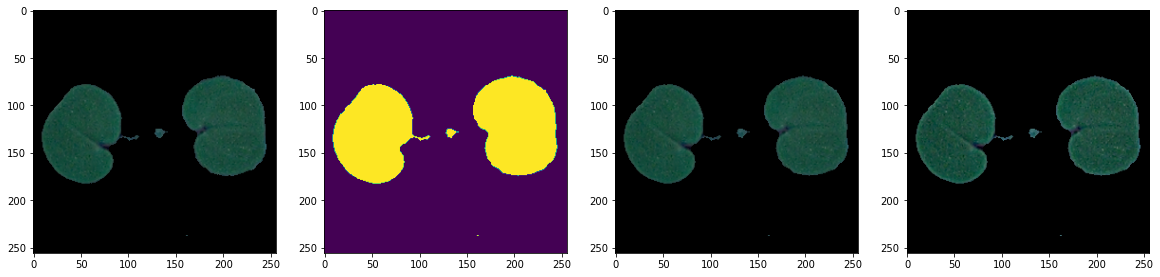

In [47]:
images = np.array(images)
classes = np.array(classes)
image = images[classes == "Small-flowered Cranesbill"][25]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [48]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [49]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

65536


**Reading the image to predict**

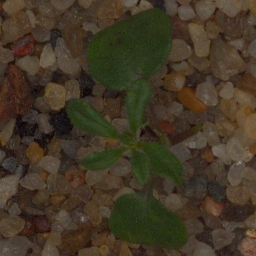

The shape of image to be predicted is:'(346, 346, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [50]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread(TRAIN_FOLDER+"/Cleavers/0a1e622bc.png")
img_pred_resize = cv2.resize(img_pred,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [51]:
#Encoding the Target Variable
enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

12

**Splitting data into training and testing set**

training set : 70%

testing set: 30%

In [59]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

**Creating validation set**

splitting test and validation sets each with 50% of data

In [60]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [61]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (3325, 256, 256, 3),(712, 256, 256, 3),(713, 256, 256, 3)


In [62]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (3325,),(712,),(713,)


Train tune and test AIML image classifier model using:

* Use supervised learning algorithms for training
* Use neural networks for training
* Use CNN for training

**Preprocessing the Data**

**Classification using Supervised Learning Techniques**

**1. Support Vector Machines**

The dataset have over 65536 features for each image and only 3776 images total in train dataset. To use an SVM, our model of choice, the number of features needs to be reduced.

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.

In [64]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [65]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [66]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((713, 65536), (713, 65536), (713, 65536))

In [67]:
n_components = 150
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [68]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [69]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.7692102561836436, 0.8583414475584278, 0.830165239720188)

In [70]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [71]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((713, 450), (713,))

In [72]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [74]:
X_train.shape[0]

3325

In [75]:
y_train.shape[0]

3325

In [76]:
svm_score = clf.score(X_val_pca, y_val)

In [77]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

**Prediction using SVM**

In [78]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [79]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [80]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'1'


In [81]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance

Model  Accuracy Loss Predicted Class
0   SVM  0.226124   NA               1

**1. Random Forest**

In [82]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [83]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'1'


In [84]:
model_performance = model_performance.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance

Model  Accuracy Loss Predicted Class
0   SVM  0.226124   NA               1
1    RF  0.279494   NA               1

**Classification using Artificial Neural Network (ANN)**

In [6]:
import itertools

import tensorflow
from tensorflow.python.keras.layers import Dense, Dropout, InputLayer,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [88]:
model = Sequential()
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, input_shape=X_train[0].shape, activation='relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

#model.add(Flatten())
model.add(Dense(12, activation='softmax'))
     

In [89]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3325, 256, 256, 3) (3325,) (713, 256, 256, 3) (713,)


In [90]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

adam_opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [91]:
with tf.device('/device:GPU:0'):
  model.fit_generator(train_generator, validation_data=validation_generator, steps_per_epoch=int(len(X_train)/32), epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 2.4921 - accuracy: 0.1796 - precision: 0.2069 - recall: 0.0128
Epoch 1: val_loss improved from inf to 2.43242, saving model to /tmp/checkpoint
103/103 [==============================] - 85s 815ms/step - loss: 2.4921 - accuracy: 0.1796 - precision: 0.2069 - recall: 0.0128 - val_loss: 2.4324 - val_accuracy: 0.0845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 2.1287 - accuracy: 0.2504 - precision: 0.4416 - recall: 0.0310
Epoch 2: val_loss improved from 2.43242 to 2.14518, saving model to /tmp/checkpoint
103/103 [==============================] - 74s 717ms/step - loss: 2.1287 - accuracy: 0.2504 - precision: 0.4416 - recall: 0.0310 - val_loss: 2.1452 - val_accuracy: 0.1943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 2.0157 - accuracy: 0.2832 - precision: 0.4543 - reca

In [92]:
model.evaluate(validation_generator)

30/30 [==============================] - 11s 320ms/step - loss: 1.3570 - accuracy: 0.5259 - precision: 0.7669 - recall: 0.2397


[1.3570226430892944,
 0.5258711576461792,
 0.7668918967247009,
 0.23970432579517365]

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 batch_normalization (BatchN  (None, 49152)            196608    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8

**3. Convolution Neural Networks (CNN)**

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [104]:
conv = Sequential()
conv.add(Conv2D(16, (3,3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
conv.add(BatchNormalization())
conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.3))

conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.3))

conv.add(GlobalMaxPooling2D())
conv.add(Dense(256, activation = "relu"))
conv.add(Dropout(0.5))
conv.add(Dense(num_classes, activation = "softmax"))



"conv.add(Flatten())\nconv.add(Dense(12))\nconv.add(Activation('softmax'))"

In [106]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
conv.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#conv.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [107]:
with tf.device('/device:GPU:0'):
  conv.fit_generator(train_generator, validation_data=validation_generator, steps_per_epoch=int(len(X_train)/32), epochs=50, callbacks=[earlystop, checkpoint])

     

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 3.0770 - accuracy: 0.1638 - precision_2: 0.1820 - recall_2: 0.0349
Epoch 1: val_loss improved from inf to 2.46296, saving model to /tmp/checkpoint


103/103 [==============================] - 114s 802ms/step - loss: 3.0770 - accuracy: 0.1638 - precision_2: 0.1820 - recall_2: 0.0349 - val_loss: 2.4630 - val_accuracy: 0.1690 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 2.0061 - accuracy: 0.3236 - precision_2: 0.6276 - recall_2: 0.0912
Epoch 2: val_loss did not improve from 2.46296
103/103 [==============================] - 74s 722ms/step - loss: 2.0061 - accuracy: 0.3236 - precision_2: 0.6276 - recall_2: 0.0912 - val_loss: 2.6355 - val_accuracy: 0.1373 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 1.6779 - accuracy: 0.4227 - precision_2: 0.6717 - recall_2: 0.1765
Epoch 3: val_loss did not improve from 2.46296
103/103 [==============================] - 75s 728ms/step - loss: 1.6779 - accuracy: 0.4227 - precision_2: 0.6717 - recall_2: 0.1765 - val_loss: 3.0062 - val_accuracy:

103/103 [==============================] - 76s 736ms/step - loss: 1.2463 - accuracy: 0.5779 - precision_2: 0.6974 - recall_2: 0.3886 - val_loss: 2.3263 - val_accuracy: 0.2270 - val_precision_2: 0.3971 - val_recall_2: 0.0876
Epoch 7/50
103/103 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.5998 - precision_2: 0.7067 - recall_2: 0.4166
Epoch 7: val_loss improved from 2.32633 to 1.58553, saving model to /tmp/checkpoint


103/103 [==============================] - 75s 732ms/step - loss: 1.1892 - accuracy: 0.5998 - precision_2: 0.7067 - recall_2: 0.4166 - val_loss: 1.5855 - val_accuracy: 0.4435 - val_precision_2: 0.7197 - val_recall_2: 0.1193
Epoch 8/50
103/103 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.6244 - precision_2: 0.7402 - recall_2: 0.4588
Epoch 8: val_loss improved from 1.58553 to 1.48568, saving model to /tmp/checkpoint


103/103 [==============================] - 75s 728ms/step - loss: 1.1219 - accuracy: 0.6244 - precision_2: 0.7402 - recall_2: 0.4588 - val_loss: 1.4857 - val_accuracy: 0.3992 - val_precision_2: 0.6115 - val_recall_2: 0.1795
Epoch 9/50
103/103 [==============================] - ETA: 0s - loss: 1.0698 - accuracy: 0.6399 - precision_2: 0.7492 - recall_2: 0.4810
Epoch 9: val_loss did not improve from 1.48568
103/103 [==============================] - 74s 719ms/step - loss: 1.0698 - accuracy: 0.6399 - precision_2: 0.7492 - recall_2: 0.4810 - val_loss: 2.4557 - val_accuracy: 0.2249 - val_precision_2: 0.3537 - val_recall_2: 0.1162
Epoch 10/50
103/103 [==============================] - ETA: 0s - loss: 0.9933 - accuracy: 0.6530 - precision_2: 0.7604 - recall_2: 0.5245
Epoch 10: val_loss improved from 1.48568 to 1.46430, saving model to /tmp/checkpoint


103/103 [==============================] - 79s 764ms/step - loss: 0.9933 - accuracy: 0.6530 - precision_2: 0.7604 - recall_2: 0.5245 - val_loss: 1.4643 - val_accuracy: 0.4731 - val_precision_2: 0.5906 - val_recall_2: 0.2513
Epoch 11/50
103/103 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.6779 - precision_2: 0.7695 - recall_2: 0.5600
Epoch 11: val_loss improved from 1.46430 to 1.27691, saving model to /tmp/checkpoint


103/103 [==============================] - 75s 727ms/step - loss: 0.9437 - accuracy: 0.6779 - precision_2: 0.7695 - recall_2: 0.5600 - val_loss: 1.2769 - val_accuracy: 0.4995 - val_precision_2: 0.6433 - val_recall_2: 0.3295
Epoch 12/50
103/103 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.6743 - precision_2: 0.7694 - recall_2: 0.5667
Epoch 12: val_loss improved from 1.27691 to 0.92370, saving model to /tmp/checkpoint


103/103 [==============================] - 77s 749ms/step - loss: 0.9330 - accuracy: 0.6743 - precision_2: 0.7694 - recall_2: 0.5667 - val_loss: 0.9237 - val_accuracy: 0.6874 - val_precision_2: 0.8051 - val_recall_2: 0.5364
Epoch 13/50
103/103 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.6829 - precision_2: 0.7691 - recall_2: 0.5801
Epoch 13: val_loss improved from 0.92370 to 0.89412, saving model to /tmp/checkpoint


103/103 [==============================] - 76s 740ms/step - loss: 0.8807 - accuracy: 0.6829 - precision_2: 0.7691 - recall_2: 0.5801 - val_loss: 0.8941 - val_accuracy: 0.7075 - val_precision_2: 0.7926 - val_recall_2: 0.5407
Epoch 14/50
103/103 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.7101 - precision_2: 0.7922 - recall_2: 0.6174
Epoch 14: val_loss did not improve from 0.89412
103/103 [==============================] - 72s 700ms/step - loss: 0.8370 - accuracy: 0.7101 - precision_2: 0.7922 - recall_2: 0.6174 - val_loss: 1.3764 - val_accuracy: 0.5195 - val_precision_2: 0.5936 - val_recall_2: 0.4488
Epoch 15/50
103/103 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.7232 - precision_2: 0.7904 - recall_2: 0.6232
Epoch 15: val_loss did not improve from 0.89412
103/103 [==============================] - 74s 722ms/step - loss: 0.8118 - accuracy: 0.7232 - precision_2: 0.7904 - recall_2: 0.6232 - val_loss: 1.7662 - val_accuracy: 0.4097 - val

In [108]:
conv.evaluate(validation_generator)

30/30 [==============================] - 11s 320ms/step - loss: 0.8941 - accuracy: 0.7075 - precision_2: 0.7926 - recall_2: 0.5407


[0.894116997718811, 0.7074973583221436, 0.792569637298584, 0.540654718875885]

In [109]:
conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                      

**4. Pick the best performing model.**

In [111]:
# CNN is the best performing model
#conv.evaluate(X_val, y_val)

In [112]:
best_plant_model = conv

**5. Import the the image in the “ Prediction” folder to predict the class.**

Display the image. Use the best trained image classifier model to predict the class

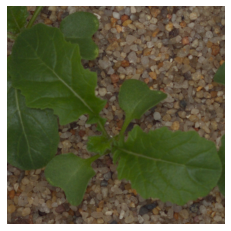

(1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.4738666e-18]]
Predicted Class of the Plant:  Charlock


In [124]:
predict_imgpath = '/content/gdrive/MyDrive/computervision/CV_PROJECT1/predict_charlock.png'
plt.subplots(1)
img = Image.open(predict_imgpath)
plt.axis('off')
plt.imshow(img)
plt.show()

pred_img = cv2.imread(predict_imgpath)
#print(pred_img.shape)
#print(pred_img[0])
pred_img = cv2.resize(pred_img, (IMAGE_SIZE*2, IMAGE_SIZE*2))
#pred_img = pred_img*1.0/255.0
img = np.expand_dims(pred_img, axis=0)
print(img.shape)
pred_plant = best_plant_model.predict(img)
print(pred_plant)
print("Predicted Class of the Plant: ", seedlings[pred_plant.argmax()])

**Saving the best model**

In [125]:
best_plant_model.save("CNN_PlantSeedling_ImageClassification.h5")

**Conclusion**

* Convolution Neural Networks outperforms Neural Networks and which in turn out perform Supervised Learning models.

* The best part of CNNs is high accuracy of image prediction and less loss. Also, we do not have to do feature extraction. The system learns to do feature extraction and the core concept of CNN is, it uses convolution of image and filters to generate invariant features which are passed on to the next layer. The features in the next layer are convoluted with different filters to generate more invariant and abstract features and the process continues till one gets final feature / output which is invariant to occlusions. 

* ANNs are better than Supervised Learning models because we don't have to perform feature extraction in ANN's whereas in Supervised Learning, we must perform the Principal component analysis (PCA) to compute the principal components in images.

* In predicting the Plant Seedlings dataset, we can see that the accuracy of Support Vector Machines, Random Forest are less than 30%. Using ANNs, the accuracy increased to 47%. This was improved much more by using CNNs. The accuracy increased to approximately 74% with less loss. 

**Part B**

• DOMAIN: Botanical research

• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo

• DATA DESCRIPTION: The dataset comprises of images from 17 plant species. It can be downloaded from TensorFlow [ Hint: import tflearn.datasets.oxflower17 as oxflower17 ]

• PROJECT OBJECTIVE: Company’s management requires an automation which can create a classifier capable of determining a flower’s species from a photo

In [68]:
import tensorflow as tf
tf.__version__

import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import pandas as pd

**1) Import the data. Analyse the dimensions of the data.**

In [67]:
flower_path = '/content/17flowers'

In [69]:

# checking dimensions of a test image
from PIL import Image
import cv2
import numpy as np
IMAGE_SIZE = 128  # Target image size for training and evaluatio

In [156]:
X, y = oxflower17.load_data(resize_pics=(224,224))

In [157]:
X.shape, y.shape

((1360, 224, 224, 3), (1360,))

**Exploring Data**

Text(0.5, 1.0, 'Displaying a random image')

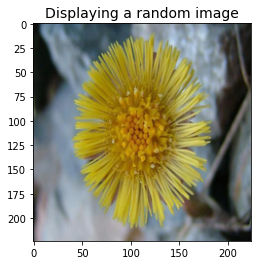

In [158]:
plt.imshow(X[50])
plt.title("Displaying a random image", fontsize=14)

In [159]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [10  1 13 ... 10  4 12]


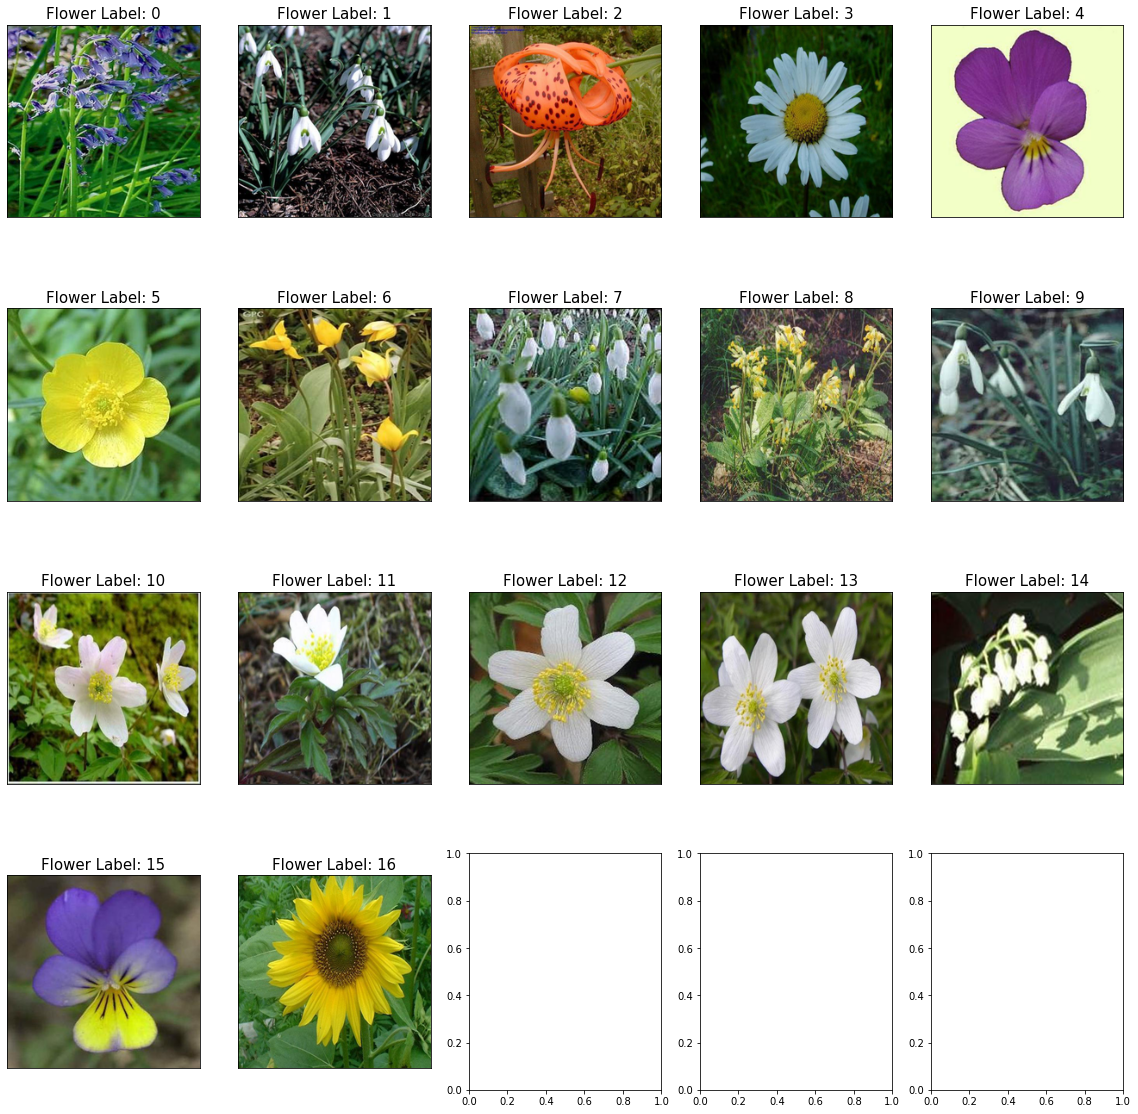

In [160]:
cols = 5
rows = int(np.ceil(len(np.unique(y))/cols))

fig, ax = plt.subplots(rows, cols, figsize=(20,20))
for i in np.unique(y):
  col = i % 5
  row = int(i/5)

  ax[row][col].imshow(X[i])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Flower Label: {i}",{'fontsize':15})
plt.show() 

**Viewing the distribution of number of images in each class**

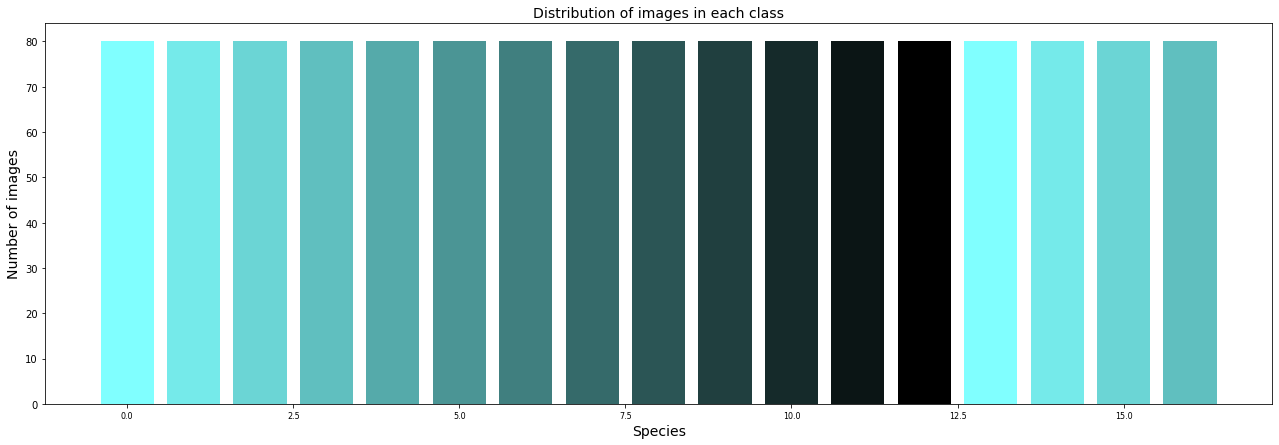

In [161]:
values =[]
labels=[]
for label in set(y):
  values.append(len(X[y == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 0, 0.5),
                (1.0, 0, .5)],
        "green": [(0, 0.5, 1.0),
                  (1.0, 0, 0)],
        "blue": [(0, 1.0, 1.0),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

**Colour image to Gray scale image**

In [162]:
def gray_scale(image):
    output = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return output

**Applying Segmentation**

In [163]:
def segment_plant(image):
    output = cv2.bitwise_and(image, image)
    return output

**Applying Sharpening**

In [164]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

**Viewing the pre-processed images**

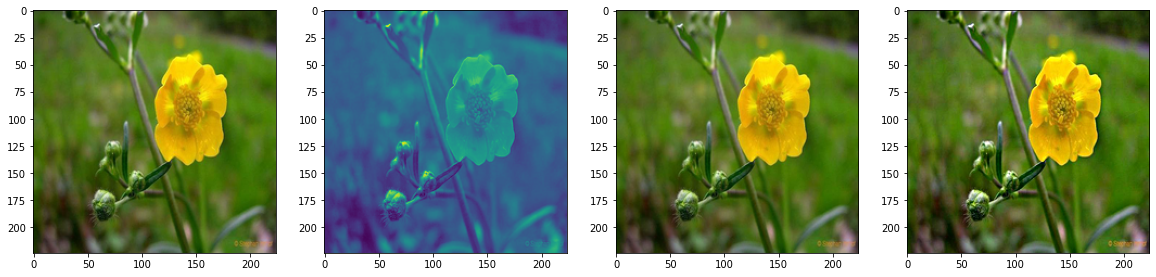

In [171]:
images = np.array(X)
classes = np.array(y)
image = X[25]


image_grayscale = gray_scale(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_grayscale)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)




**2) Preprocess the data.**

**Image Data Augmentation for Deep Learning and CNN**

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [72]:
datapath = flower_path + '/jpg/'

# Image augmentation
tr_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2, rotation_range=20,
        zoom_range=0.2, width_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True,
        validation_split=0.2)
val_datagen = ImageDataGenerator(validation_split=0.2) #, rescale=1./255)
tr_generator = tr_datagen.flow_from_directory(
        datapath,
        batch_size=32,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode='categorical',
        subset='training')
val_generator = val_datagen.flow_from_directory(
        datapath,
        batch_size=32,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode='categorical',
        subset='validation', shuffle=False)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [73]:
train_count = tr_generator.samples
print('Number of training Batches: ',int(train_count/32))

Number of training Batches:  34


In [74]:
val_count = val_generator.samples
print('Number of validation Batches: ',int(val_count/32))

Number of validation Batches:  8


In [75]:
# Store the data in X_train, y_train variables by iterating over the batches
tr_generator.reset()
X_train, y_train = next(tr_generator)
for i in tqdm(range(int(train_count/32)-1)):
  img, label = next(tr_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 33/33 [00:11<00:00,  2.92it/s]

(1088, 128, 128, 3) (1088, 17)


In [76]:
# Store the data in X_val, y_val variables by iterating over the batches
val_generator.reset()
X_val, y_val = next(val_generator)
for i in tqdm(range(int(val_count/32)-1)):
  img, label = next(val_generator)
  X_val = np.append(X_val, img, axis=0 )
  y_val = np.append(y_val, label, axis=0)
print(X_val.shape, y_val.shape)

100%|██████████| 7/7 [00:01<00:00,  5.89it/s]

(256, 128, 128, 3) (256, 17)


In [77]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1088, 128, 128, 3) (1088, 17) (256, 128, 128, 3) (256, 17)


In [78]:
flowers_dict = tr_generator.class_indices
print('Available classes: ', flowers_dict)
flowers_dict.values
a = list(flowers_dict.items())
flowers_np = np.array(a)
flowers = flowers_np[:,0]
print('\n After converting the dictionary into simple array: \n', flowers)
print('\n Referencing a class with index: ', flowers[10])

Available classes:  {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16}

 After converting the dictionary into simple array: 
 ['0' '1' '10' '11' '12' '13' '14' '15' '16' '2' '3' '4' '5' '6' '7' '8'
 '9']

 Referencing a class with index:  3


In [79]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1088, 128, 128, 3) (1088, 17) (256, 128, 128, 3) (256, 17)


In [80]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**Prepare data for SVM**

In [81]:
# Flatten the images for SVM
X_train_flat = X_train.reshape(X_train.shape[0], IMAGE_SIZE*IMAGE_SIZE*3)
X_train_flat.shape
     

(1088, 49152)

In [82]:
# Function to convert y variable into categorical labeled data for SVM
def f(x):
    return flowers[x.argmax()]

In [83]:
y_train_flat = np.array(list(map(f,y_train)))
y_train_flat[10]

'16'

In [84]:
print(y_train_flat.shape)
print(np.unique(y_train_flat))

(1088,)
['0' '1' '10' '11' '12' '13' '14' '15' '16' '2' '3' '4' '5' '6' '7' '8'
 '9']


In [85]:
#Similarly for Validation Data
X_val_flat = X_val.reshape(X_val.shape[0], IMAGE_SIZE*IMAGE_SIZE*3)
y_val_flat = np.array(list(map(f,y_val)))
print(X_val_flat.shape, y_val_flat.shape)

(256, 49152) (256,)


**3) Data visualisation:**

* Display the images
* Display the labels
* Display images vs labels
* Apply different filters [ for example: blur, contour, edge detection, emboss, smooth etc.] on the images and display the image

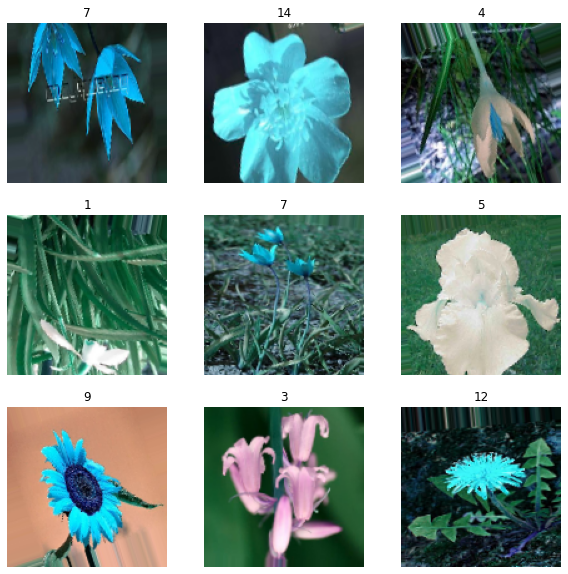

In [87]:
tr_generator.reset()
image_batch, label_batch = next(tr_generator)
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  #plt.imshow( image_batch[i].astype('uint8'),cv2.COLOR_BGR2RGB)
  plt.imshow(cv2.cvtColor(image_batch[i].astype('uint8'),cv2.COLOR_BGR2RGB)) 
  label = label_batch[i].astype('uint8')
  #print(label.argmax())
  plt.title(flowers[label.argmax()])
  #print(label)
  plt.axis('off')

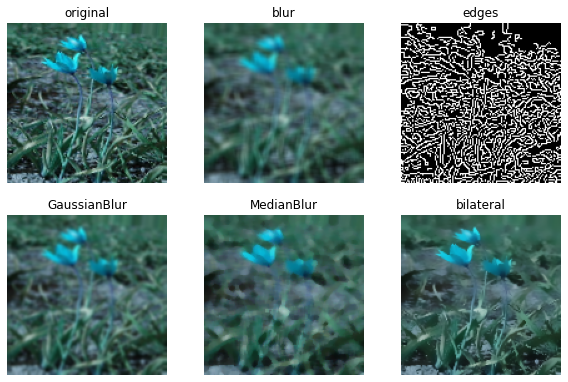

In [88]:
# Apply different filters [ for example: blur, contour, edge detection, emboss, smooth etc.] on the images and display the image

plt.figure(figsize=(10,10))
target_image = image_batch[4]
target_label = label_batch[4]

def plot_img(title, target_image, i):
  ax = plt.subplot(3, 3, i)
  plt.imshow(cv2.cvtColor(target_image.astype('uint8'),cv2.COLOR_BGR2RGB))
  #print(label.argmax())
  plt.title(title)
  #print(label)
  plt.axis('off')

original = target_image
plot_img('original', original, 1)

blur = cv2.blur(target_image, (5,5))
plot_img('blur', blur, 2)

edges = cv2.Canny(target_image.astype('uint8'), 100, 200) # Edge detection
plot_img('edges', edges, 3)

gaussian = cv2.GaussianBlur(target_image, (5,5), 0)
plot_img('GaussianBlur', gaussian, 4)

median = cv2.medianBlur(target_image, 5)
plot_img('MedianBlur', median, 5)

bilateral = cv2.bilateralFilter(target_image, 9, 75, 75)
plot_img('bilateral', bilateral, 6)
     

**4) Train tune and test AIML image classifier model using:**

* Use supervised learning algorithms for training
* Use neural networks for training
* Use CNN for training
* Use various CNN with transferred learning models for training

Compare the results from the above step along with your detailed observations.

**1. Supervised Learning: SVM**

In [89]:
from sklearn.svm import SVC
svc = SVC()
with tf.device('/device:GPU:0'):
  svc.fit(X_train_flat, y_train_flat)

In [90]:
with tf.device('/device:GPU:0'):
  svc_score = svc.score(X_val_flat, y_val_flat)

In [91]:
print(svc_score)

0.38671875


In [93]:
from sklearn.metrics import classification_report
y_pred_svc = svc.predict(X_val_flat)
print(classification_report(y_val_flat, y_pred_svc))

              precision    recall  f1-score   support

           0       0.35      0.44      0.39        16
           1       0.10      0.06      0.08        16
          10       0.39      0.81      0.53        16
          11       0.29      0.12      0.17        16
          12       0.31      0.69      0.43        16
          13       1.00      0.06      0.12        16
          14       0.36      0.50      0.42        16
          15       0.46      0.38      0.41        16
          16       0.17      0.12      0.14        16
           2       0.64      0.44      0.52        16
           3       0.29      0.31      0.30        16
           4       0.19      0.25      0.22        16
           5       0.63      0.75      0.69        16
           6       0.82      0.88      0.85        16
           7       0.20      0.06      0.10        16
           8       0.62      0.31      0.42        16
           9       0.00      0.00      0.00         0

    accuracy              

2. **Aritfical Neural Network**

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [95]:
# Define the Dense Neural network model
model = Sequential()
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, input_shape=X_train[0].shape, activation='relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(17, activation='softmax'))
     

In [96]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)  

X_train.shape[1:]

(128, 128, 3)

In [97]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1088, 128, 128, 3) (1088, 17) (256, 128, 128, 3) (256, 17)


In [98]:
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
     

In [102]:
  model.fit(tr_generator, validation_data=val_generator, steps_per_epoch=int(len(X_train)/32), epochs=100, callbacks=[earlystop, checkpoint])

Epoch 1/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 3.2748 - acc: 0.0561 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 5.00635, saving model to /tmp/checkpoint
34/34 [==============================] - 23s 540ms/step - batch: 16.5000 - size: 32.0000 - loss: 3.2748 - acc: 0.0561 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 5.0064 - val_acc: 0.1360 - val_precision: 0.1507 - val_recall: 0.0809
Epoch 2/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 3.0533 - acc: 0.0873 - precision: 0.0500 - recall: 9.1912e-04
Epoch 2: val_loss improved from 5.00635 to 3.12848, saving model to /tmp/checkpoint
34/34 [==============================] - 22s 645ms/step - batch: 16.5000 - size: 32.0000 - loss: 3.0533 - acc: 0.0873 - precision: 0.0500 - recall: 9.1912e-04 - val_loss: 3.1285 - val_acc: 0.1581 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10

In [103]:
model.evaluate(X_val, y_val)

[1.949341058731079, 0.2734375, 0.6666667, 0.046875]

In [104]:
model.evaluate(val_generator)

[1.7773680686950684, 0.31617647, 0.8125, 0.09558824]

In [105]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 batch_normalization_12 (Bat  multiple                 196608    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            multiple                  6291584   
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 batch_normalization_13 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            multiple                 

**3. Convolution Neural Networks (CNN)**

In [106]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [108]:
conv = Sequential()
conv.add(Conv2D(128, (3,3), padding='same', input_shape=X_train.shape[1:]))
conv.add(BatchNormalization())
conv.add(Activation('relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.4))

conv.add(Conv2D(64, (3,3), padding='same'))
conv.add(BatchNormalization())
conv.add(Activation('relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.4))

conv.add(Conv2D(16, (3,3), padding='same'))
conv.add(BatchNormalization())
conv.add(Activation('relu'))
conv.add(Dropout(0.4))

conv.add(Flatten())
conv.add(Dropout(0.4))
conv.add(Dense(17))
conv.add(Activation('softmax'))
     



In [109]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
     

In [110]:
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
conv.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [111]:
conv.fit(tr_generator, validation_data=val_generator, steps_per_epoch=int(len(X_train)/32), epochs=100, callbacks=[earlystop, checkpoint])

Epoch 1/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 3.7172 - acc: 0.1406 - precision_2: 0.1800 - recall_2: 0.0763
Epoch 1: val_loss improved from inf to 9.00589, saving model to /tmp/checkpoint
34/34 [==============================] - 144s 4s/step - batch: 16.5000 - size: 32.0000 - loss: 3.7172 - acc: 0.1406 - precision_2: 0.1800 - recall_2: 0.0763 - val_loss: 9.0059 - val_acc: 0.2353 - val_precision_2: 0.2364 - val_recall_2: 0.2243
Epoch 2/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.6469 - acc: 0.2840 - precision_2: 0.3556 - recall_2: 0.2004
Epoch 2: val_loss improved from 9.00589 to 5.76518, saving model to /tmp/checkpoint
34/34 [==============================] - 137s 4s/step - batch: 16.5000 - size: 32.0000 - loss: 2.6469 - acc: 0.2840 - precision_2: 0.3556 - recall_2: 0.2004 - val_loss: 5.7652 - val_acc: 0.2647 - val_precision_2: 0.2749 - val_recall_2: 0.2537
Epoch 3/100
34/34 [===

In [112]:
conv.evaluate(val_generator)

[1.4244534009032779, 0.5110294, 0.63265306, 0.45588234]

In [113]:
conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)       

**4. Transfer Learning with CNN**

Function based code
To evaluate various models, create_model and compile_model functions have been defined

In [114]:
# Working Model
def create_model(base_model):
  cnn = Sequential()
  cnn.add(base_model)
  cnn.add(Flatten())
  cnn.add(Dense(512, activation='relu'))
  cnn.add(BatchNormalization())
  cnn.add(Dense(128, activation='relu'))
  cnn.add(BatchNormalization())
  cnn.add(Dense(17, activation='softmax'))
  cnn.summary()
  return cnn

In [115]:
# Testing
def create_model(base_model):
  cnn = Sequential()
  cnn.add(base_model)
  cnn.add(Flatten())
  cnn.add(BatchNormalization())
  cnn.add(Dense(256, activation='relu'))
  cnn.add(BatchNormalization())
  cnn.add(Dense(128, activation='relu'))  
  cnn.add(BatchNormalization())
  cnn.add(Dense(17, activation='softmax'))
  cnn.summary()
  return cnn

In [121]:
def compile_model(cnn, lr):
  # Add Callbacks to pick the best model parameters
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
  checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

  # Define an optimizer and compile the model
  adam_opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=True)
  cnn.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  cnn.fit_generator(tr_generator, validation_data=val_generator, steps_per_epoch=int(len(X_train)/32), epochs=100, callbacks=[earlystop, checkpoint])
  #print(cnn.evaluate(val_generator))
  return cnn

**a. Transfer learning with VGG16**

In [117]:
# Transfer learning with VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg')
vgg.trainable = False
model_vgg = create_model(vgg)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_21 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_22 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                       

In [122]:
model_vgg = compile_model(model_vgg, lr=0.01)
model_vgg.evaluate(val_generator)

Epoch 1/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 1.7144 - acc: 0.4908 - precision_6: 0.6864 - recall_6: 0.3842
Epoch 1: val_loss improved from inf to 3.61141, saving model to /tmp/checkpoint
34/34 [==============================] - 236s 7s/step - batch: 16.5000 - size: 32.0000 - loss: 1.7144 - acc: 0.4908 - precision_6: 0.6864 - recall_6: 0.3842 - val_loss: 3.6114 - val_acc: 0.5919 - val_precision_6: 0.6178 - val_recall_6: 0.5882
Epoch 2/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 0.8678 - acc: 0.7243 - precision_6: 0.8141 - recall_6: 0.6360
Epoch 2: val_loss improved from 3.61141 to 2.06933, saving model to /tmp/checkpoint
34/34 [==============================] - 231s 7s/step - batch: 16.5000 - size: 32.0000 - loss: 0.8678 - acc: 0.7243 - precision_6: 0.8141 - recall_6: 0.6360 - val_loss: 2.0693 - val_acc: 0.6912 - val_precision_6: 0.7099 - val_recall_6: 0.6838
Epoch 3/100
34/34 [===

[0.48631031190355617, 0.83455884, 0.8528302, 0.8308824]

In [123]:
model_vgg.evaluate(val_generator)

[0.48631031190355617, 0.83455884, 0.8528302, 0.8308824]

**b. Tranfer learning with Inception net**

In [124]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='max')
inception.trainable = False
model_inc = create_model(inception)

87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_118 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_119 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                       

In [125]:
# Compile and fit the model
model_inc = compile_model(model_inc, lr=0.01)
model_inc.evaluate(val_generator)
     

Epoch 1/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.7554 - acc: 0.2022 - precision_7: 0.5000 - recall_7: 0.0469
Epoch 1: val_loss improved from inf to 512.97432, saving model to /tmp/checkpoint
34/34 [==============================] - 57s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.7554 - acc: 0.2022 - precision_7: 0.5000 - recall_7: 0.0469 - val_loss: 512.9743 - val_acc: 0.0441 - val_precision_7: 0.0441 - val_recall_7: 0.0441
Epoch 2/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.0672 - acc: 0.3594 - precision_7: 0.6550 - recall_7: 0.1553
Epoch 2: val_loss improved from 512.97432 to 254.67521, saving model to /tmp/checkpoint
34/34 [==============================] - 52s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.0672 - acc: 0.3594 - precision_7: 0.6550 - recall_7: 0.1553 - val_loss: 254.6752 - val_acc: 0.0294 - val_precision_7: 0.0294 - val_recall_7: 0.0294
Epoch 3/100
34

[151.17408921983508, 0.04411765, 0.04411765, 0.04411765]

In [126]:
model_inc.evaluate(val_generator)

[151.17408921983508, 0.04411765, 0.04411765, 0.04411765]

**c. Tranfer learning with Mobilenet**

In [127]:
from tensorflow.keras.applications.mobilenet import MobileNet
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='max')
mobilenet.trainable = False
model_mob = create_model(mobilenet)

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_121 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_122 (Ba  (None, 256)              1024      
 tchNormalization)                                     

In [128]:
# Compile and fit the model
model_mob = compile_model(model_mob, lr=0.01)
model_mob.evaluate(val_generator)

Epoch 1/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 1.1826 - acc: 0.6452 - precision_8: 0.7561 - recall_8: 0.5671
Epoch 1: val_loss improved from inf to 9.97255, saving model to /tmp/checkpoint
34/34 [==============================] - 34s 930ms/step - batch: 16.5000 - size: 32.0000 - loss: 1.1826 - acc: 0.6452 - precision_8: 0.7561 - recall_8: 0.5671 - val_loss: 9.9726 - val_acc: 0.1581 - val_precision_8: 0.1615 - val_recall_8: 0.1544
Epoch 2/100
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 0.4931 - acc: 0.8290 - precision_8: 0.8777 - recall_8: 0.7914
Epoch 2: val_loss improved from 9.97255 to 5.75427, saving model to /tmp/checkpoint
34/34 [==============================] - 30s 889ms/step - batch: 16.5000 - size: 32.0000 - loss: 0.4931 - acc: 0.8290 - precision_8: 0.8777 - recall_8: 0.7914 - val_loss: 5.7543 - val_acc: 0.1875 - val_precision_8: 0.1991 - val_recall_8: 0.1654
Epoch 3/100
34/34 

[4.024498462677002, 0.18382353, 0.1943128, 0.15073529]

In [129]:
model_mob.evaluate(val_generator)

[4.024498462677002, 0.18382353, 0.1943128, 0.15073529]

**Picking the best model**

In [130]:
best_flower_model = model_vgg

In [149]:
model_vgg.save("CNN_with_VGG16.h5")

**5) Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.**

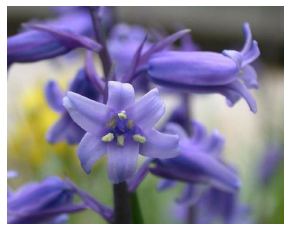

(1, 128, 128, 3)
[[2.0883517e-02 9.9981762e-03 2.1468492e-03 6.0893937e-05 4.8477494e-04
  3.1026334e-03 2.0137762e-05 7.3372826e-02 4.6827599e-01 9.6079451e-04
  2.2214489e-01 1.3468494e-03 5.1548489e-04 3.6969457e-03 1.8900268e-01
  9.4307812e-05 3.8922944e-03]]
Predicted Class of the flower:  16


In [154]:
predict_imgpath = '/content/drive/MyDrive/computervision/CV_PROJECT1/prediction_flower/prediction.jpg'
plt.subplots(1)
img = Image.open(predict_imgpath)
plt.axis('off')
plt.imshow(img)
plt.show()

pred_img = cv2.imread(predict_imgpath)
#print(pred_img.shape)
#print(pred_img[0])
pred_img = cv2.resize(pred_img, (IMAGE_SIZE, IMAGE_SIZE))
#pred_img = pred_img*1.0/255.0
img = np.expand_dims(pred_img, axis=0)
print(img.shape)
pred_flower = best_flower_model.predict(img)
print(pred_flower)
print("Predicted Class of the flower: ", flowers[pred_flower.argmax()])